In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("llm_comparison_results.csv")

In [3]:
df.columns

Index(['model', 'result'], dtype='object')

In [5]:
gt_patient = "Michael Lewis"
gt_medi_prof_1 = "Tom Bradley"
gt_medi_prof_2 = "Carla Jennings"
gt_family_member = "Amanda Lewis"

In [20]:
identified_patient = []
identified_medi_profs = []

for i in range(len(df)):
    model = df.iloc[i]["model"]
    response = df.iloc[i]["result"]
    gen_patient = response.split("\n")[0].split(":")[1].strip()
    gen_medi_profs= response.split("\n")[1].split(":")[1].strip()

    if gt_patient.lower() in gen_patient.lower():
        identified_patient.append(1)
    else:
        identified_patient.append(0)

    if (gt_medi_prof_1.lower() in gen_medi_profs.lower()) and (gt_medi_prof_2.lower() in gen_medi_profs.lower()) and (gt_family_member.lower() not in gen_medi_profs.lower()):
        identified_medi_profs.append(1)
    else:
        identified_medi_profs.append(0)
    if model == "llama3.1:8b":
        print(f"{i+1}. Model: {model}")
        print(f"Identified Patient: {gen_patient}")
        print(f"Identified Medical Professionals: {gen_medi_profs}")
        print()


2. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Nurse Tom Bradley, Dr. Amanda Lewis

7. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Nurse Tom Bradley, Dr. Amanda Lewis

12. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Dr. Amanda Lewis (also husband's wife) , Nurse Tom Bradley

17. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Nurse Tom Bradley

22. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Nurse Tom Bradley

27. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Nurse Tom Bradley, Dr. Amanda Lewis

32. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Nurse Tom Bradle

In [14]:
df["correct_patient"] = identified_patient
df["correct_medi_profs"] = identified_medi_profs

df.to_csv("llm_comparison_results-identified.csv", index=False, encoding="utf-8-sig")

In [15]:
df_grouped = df.groupby("model").sum().reset_index()

In [46]:
df_grouped = df_grouped[["model","correct_patient", "correct_medi_profs"]]

In [47]:
df_grouped["correct_patient_percentage"] = df_grouped["correct_patient"] / 50 * 100
df_grouped["correct_medi_profs_percentage"] = df_grouped["correct_medi_profs"] / 50 * 100

In [52]:
df_grouped.sort_values(by="model", ascending=True, inplace=True)

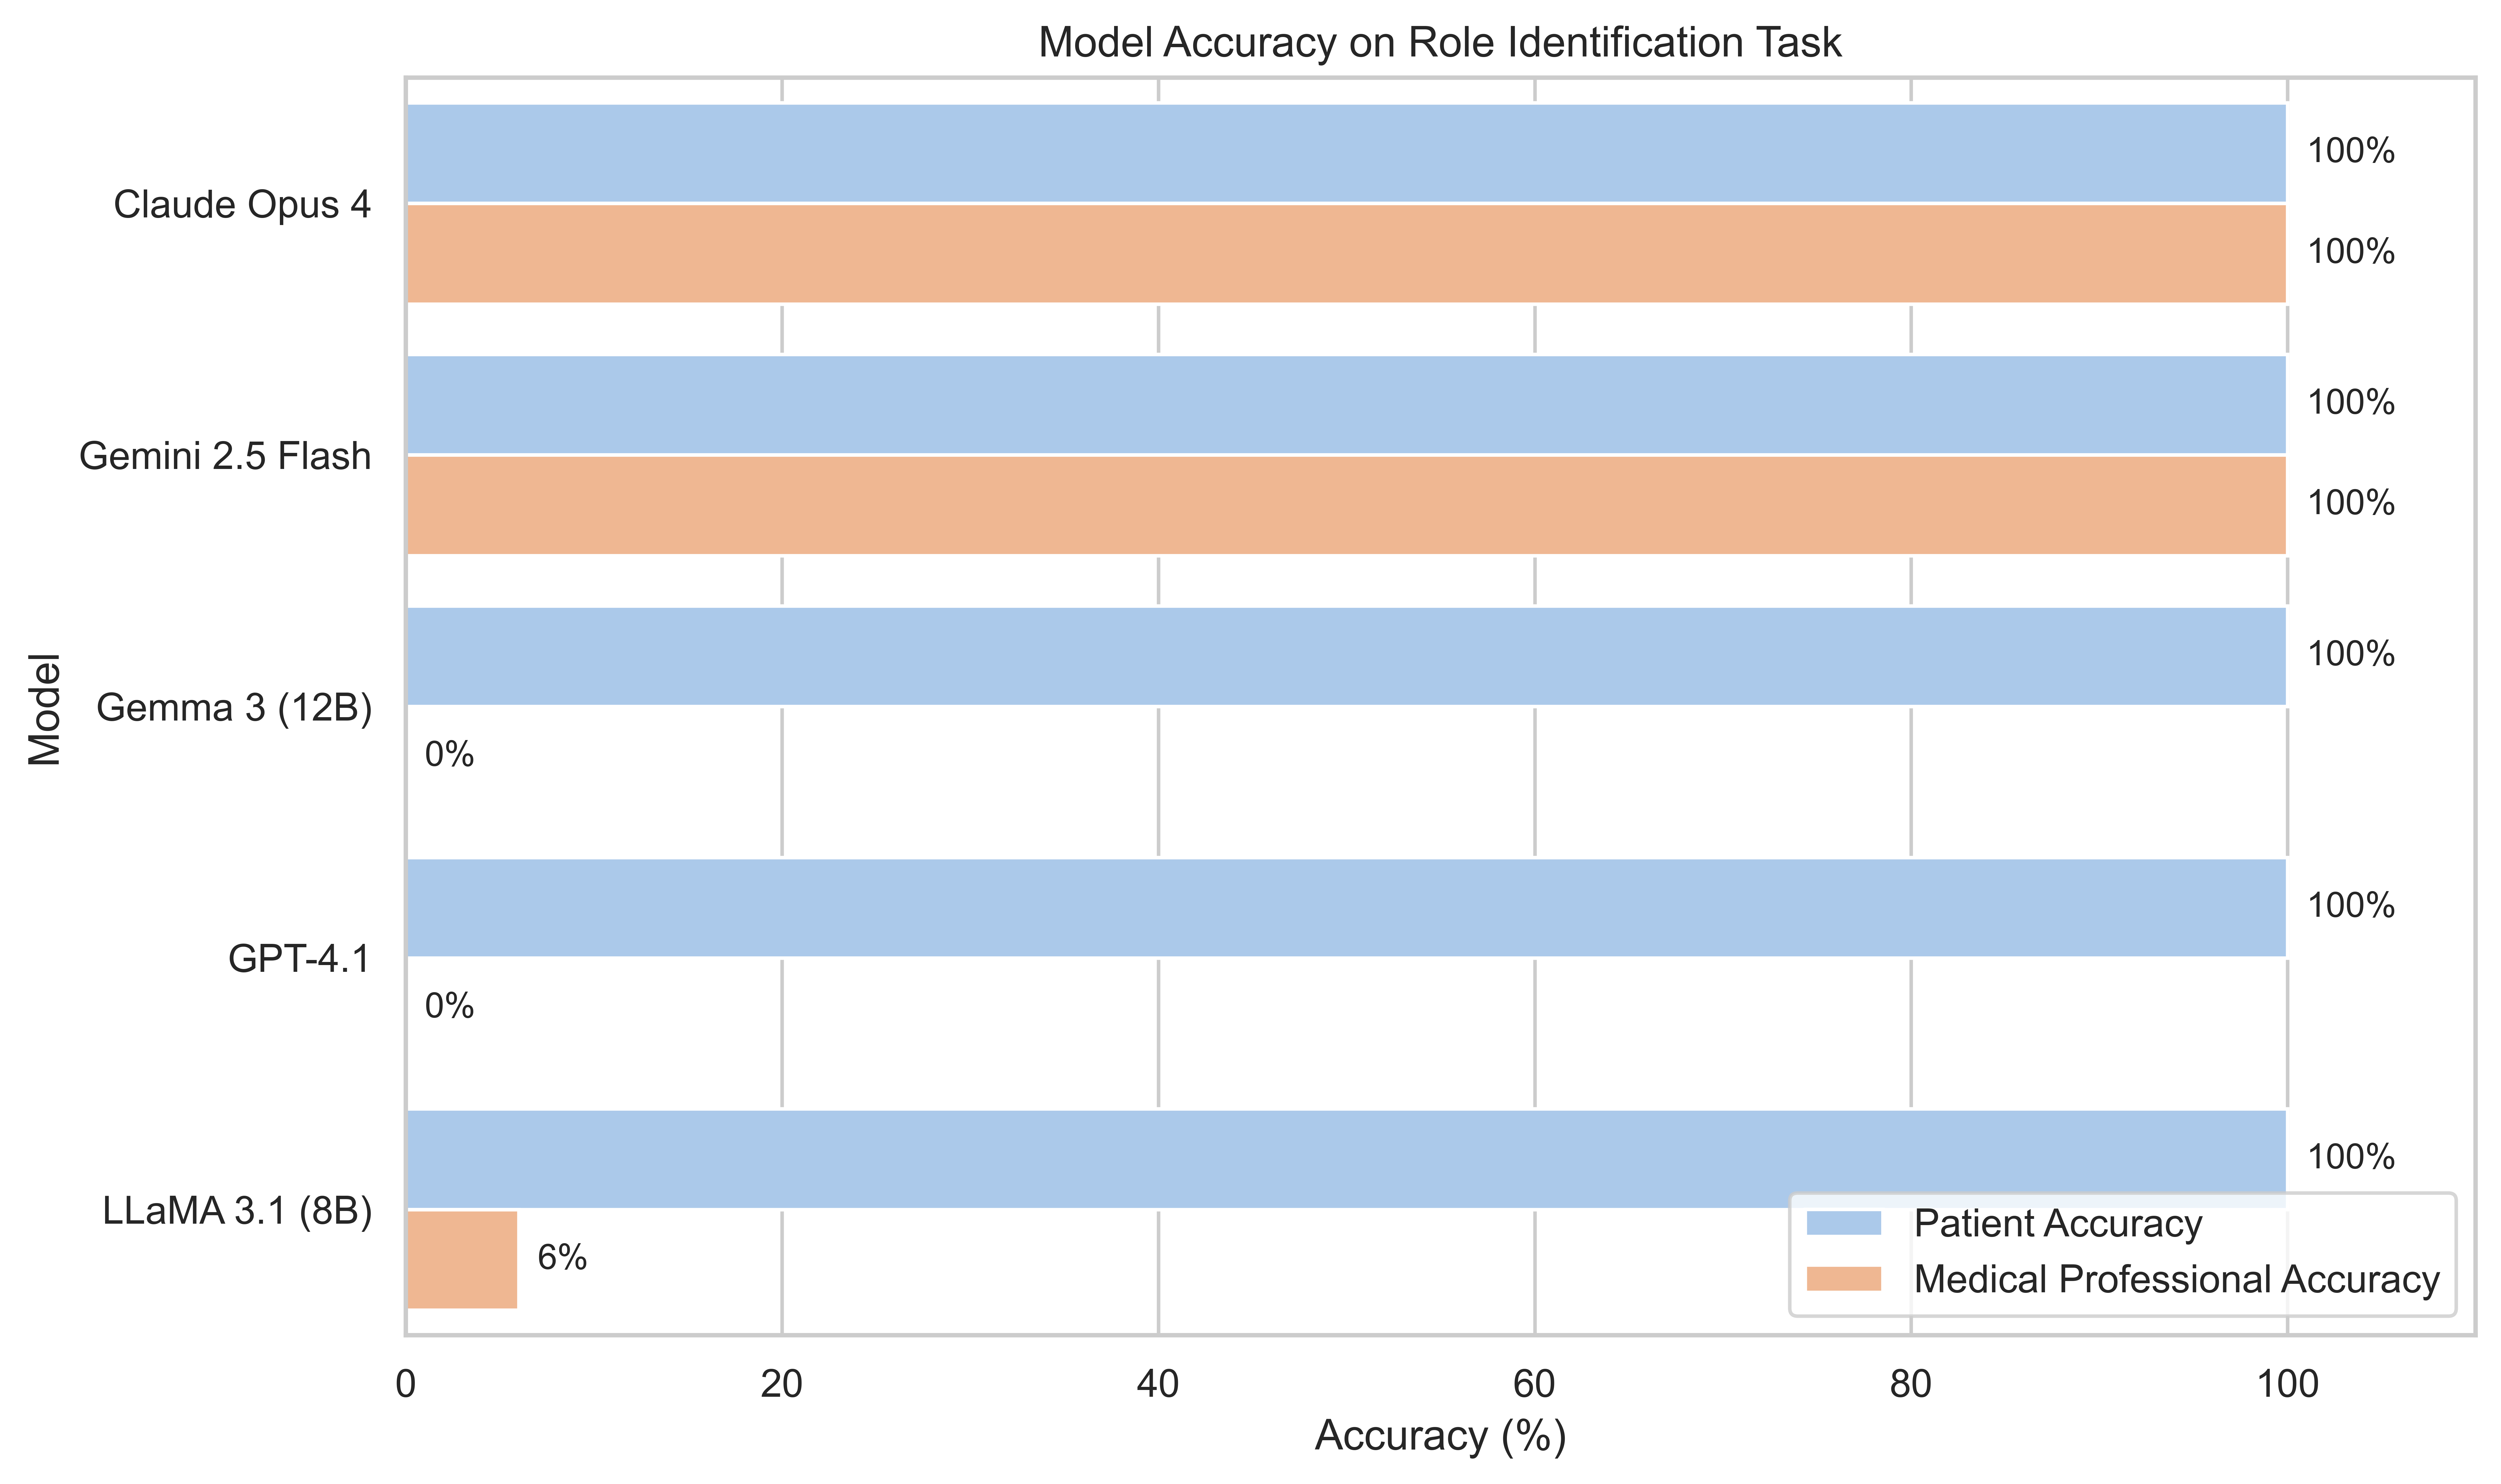

In [56]:
model_name_map = {
    'claude-opus-4-20250514': 'Claude Opus 4',
    'gemini2.5-flash': 'Gemini 2.5 Flash',
    'gemma3:12b': 'Gemma 3 (12B)',
    'gpt-4.1': 'GPT-4.1',
    'llama3:1:8b': 'LLaMA 3.1 (8B)'
}

df_grouped['model_clean'] = df_grouped['model'].map(model_name_map)

df_melted = df_grouped.melt(
    id_vars='model_clean',
    value_vars=['correct_patient_percentage', 'correct_medi_profs_percentage'],
    var_name='Metric',
    value_name='Accuracy'
)


df_melted['Metric'] = df_melted['Metric'].replace({
    'correct_patient_percentage': 'Patient Accuracy',
    'correct_medi_profs_percentage': 'Medical Professional Accuracy'
})


sns.set(style='whitegrid')
plt.figure(figsize=(10, 6), dpi=900)
ax = sns.barplot(
    x='Accuracy',
    y='model_clean',
    hue='Metric',
    data=df_melted,
    palette='pastel'
)


for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(
            width + 1,
            y,
            f'{width:.0f}%',
            va='center',
            ha='left',
            fontsize=10
        )

plt.title('Model Accuracy on Role Identification Task')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')
plt.xlim(0, 110)
plt.legend(title='')
plt.tight_layout()
plt.show()
